## **Introduction**

This notebook documents the steps taken to develop a machine learning model for detecting diseases in tea plants. The project involves data collection, preprocessing, model training using MobileNet, and deployment on the cloud.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Libraries Used**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import ( Dense,
                                      Conv2D,
                                      Flatten,
                                      Dropout,
                                      MaxPooling2D,
                                      GlobalAveragePooling2D )

## **Data Collection and Data Preprocessing**

The dataset was sourced from Kaggle, consisting of images of tea leaves with various diseases. After it was imported the data was cleaned and prepared for model training. This involved normalizing image data, rescaling, and splitting the dataset into training and testing sets.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/drive/MyDrive/Colab Notebooks/Bangkit Capstone/dataset'

batch_size = 64
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1],
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3840 images belonging to 6 classes.
Found 960 images belonging to 6 classes.


## **Visualizing Class Distribution in Training and Validation Generators**

Vsualizing the distribution of classes within the training and validation generators. The bar charts illustrate the number of samples per class, providing insights into the balance or imbalance of class representation across the datasets used for training and validation.

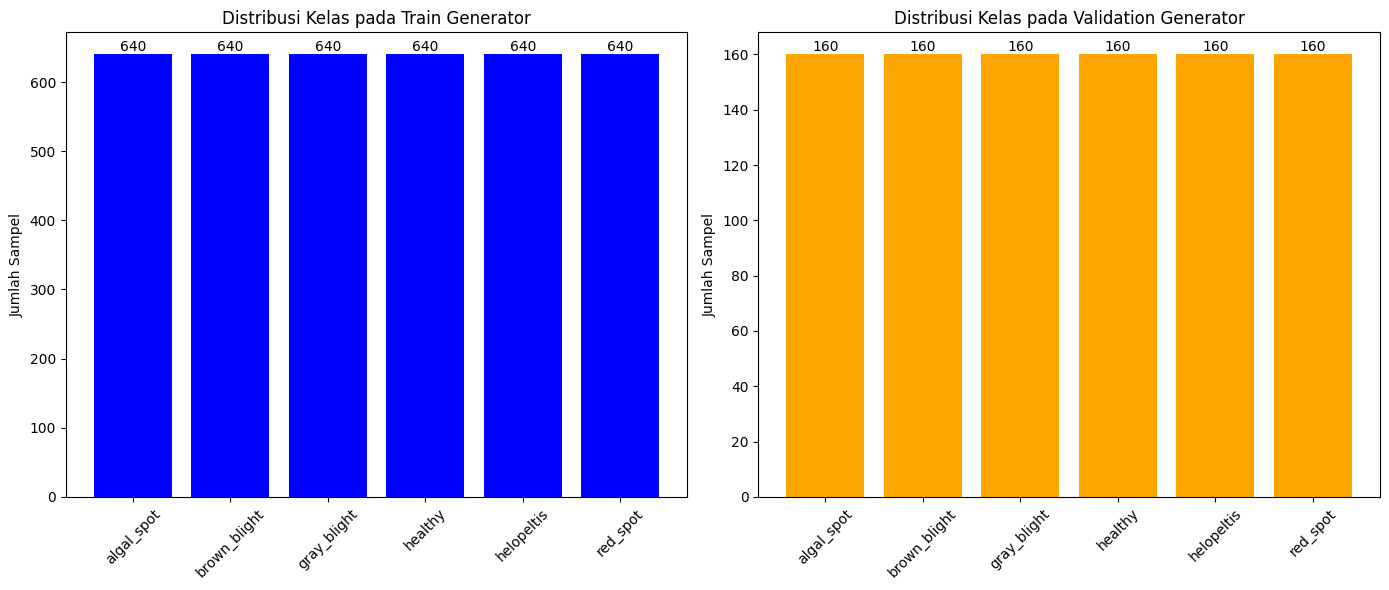

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_classes = len(train_generator.class_indices)

train_class_counts = np.sum(train_generator.labels == np.arange(num_classes)[:, None], axis=1)

val_class_counts = np.sum(validation_generator.labels == np.arange(num_classes)[:, None], axis=1)

class_labels = list(train_generator.class_indices.keys())

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

bars_train = ax[0].bar(class_labels, train_class_counts, color='blue')
ax[0].set_title('Distribusi Kelas pada Train Generator')
ax[0].set_ylabel('Jumlah Sampel')

for bar, count in zip(bars_train, train_class_counts):
    ax[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                ha='center', va='bottom')

bars_val = ax[1].bar(class_labels, val_class_counts, color='orange')
ax[1].set_title('Distribusi Kelas pada Validation Generator')
ax[1].set_ylabel('Jumlah Sampel')

for bar, count in zip(bars_val, val_class_counts):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                ha='center', va='bottom')

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## **Model Training**

The model was trained and evaluated to ensure high accuracy and to prevent overfitting.

Initially, we employed MobileNet as our base model for transfer learning in the application. Subsequently, after deploying the model, we proceeded to train additional models in pursuit of achieving superior performance compared to the initial model. This subsequent model training was implemented in the second notebook cell.

In [ ]:
num_classes = len(train_generator.class_indices)

model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    #Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# base_model = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

# for layer in base_model.layers:
#   layer.trainable = False

# num_classes = len(train_generator.class_indices)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.5)(x)
# prediction_layers = Dense(num_classes, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=prediction_layers)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
60/60 [==============================] - 65s 894ms/step - loss: 2.0902 - accuracy: 0.2701 - val_loss: 1.2479 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 58s 968ms/step - loss: 1.3286 - accuracy: 0.4065 - val_loss: 1.1404 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 59s 985ms/step - loss: 1.1732 - accuracy: 0.5042 - val_loss: 0.9223 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 4/50
60/60 [==============================] - 58s 963ms/step - loss: 1.0294 - accuracy: 0.5846 - val_loss: 0.7787 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 5/50
60/60 [==============================] - 58s 963ms/step - loss: 0.9599 - accuracy: 0.6068 - val_loss: 0.7159 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 6/50
60/60 [==============================] - 57s 953ms/step - loss: 0.8945 - accuracy: 0.6344 - val_loss: 0.6784 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 7/50
60/60 [==============================] - 58s 963ms/st

## **Model Performance Evaluation and Confusion Matrix**

Evaluating the performance of the trained model including metrics such as accuracy, precision, recall, and F1-score to assess the model's effectiveness in classification tasks.

Additionally, a confusion matrix is used to visualized the model's predictive performance across different classes, providing insights into where the model may have challenges or strengths in classification. These evaluations are crucial for understanding the overall efficacy and reliability of the model in real-world applications.

15/15 [==============================] - 3s 140ms/step
Accuracy: 0.1854
Precision: 0.1851
Recall: 0.1854
F1-Score: 0.1851

Classification Report:

              precision    recall  f1-score   support

  algal_spot       0.24      0.24      0.24       160
brown_blight       0.20      0.21      0.20       160
 gray_blight       0.20      0.18      0.19       160
     healthy       0.18      0.18      0.18       160
  helopeltis       0.18      0.18      0.18       160
    red_spot       0.12      0.12      0.12       160

    accuracy                           0.19       960
   macro avg       0.19      0.19      0.19       960
weighted avg       0.19      0.19      0.19       960



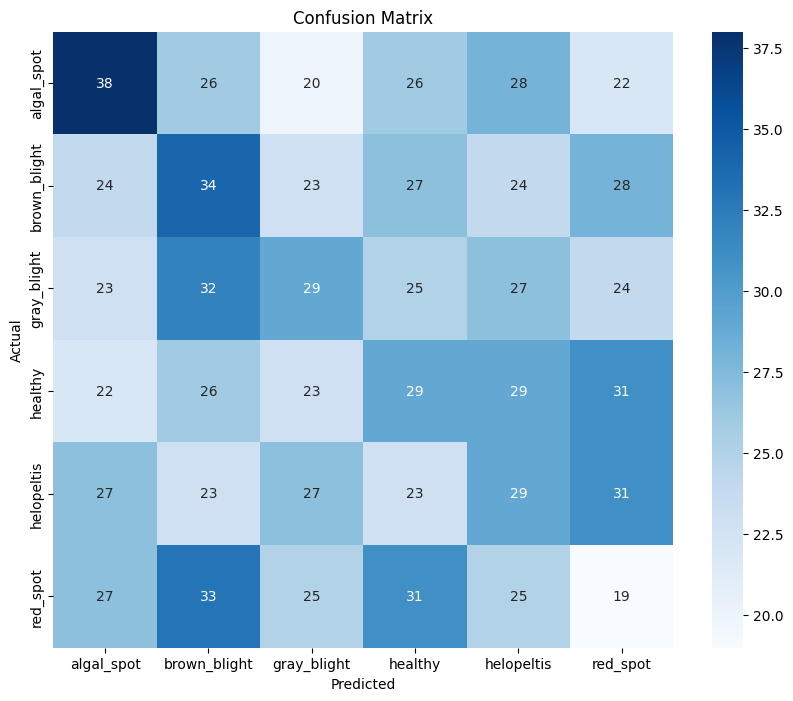

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

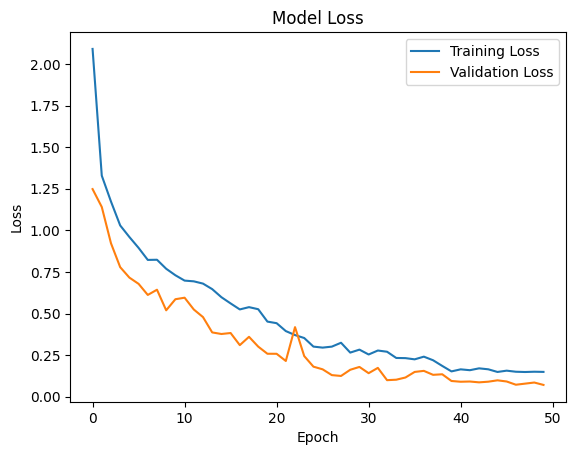

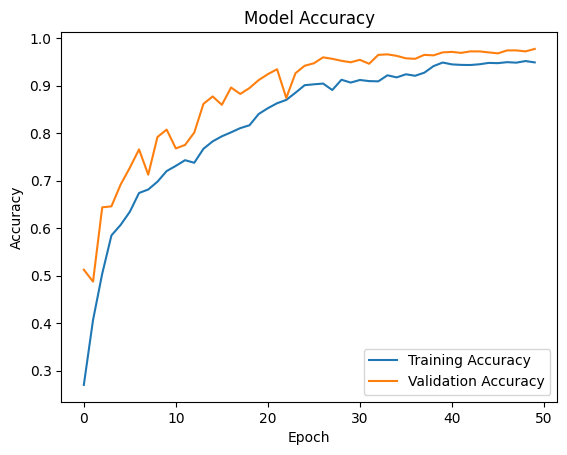

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Model Saving**

In [ ]:
import os

save_path = '/content/models/cultivitea/ver19/'
os.makedirs(save_path, exist_ok=True)
model.save(save_path)

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('cultivitea_model_ver19', 'zip', save_path)
files.download('cultivitea_model_ver19.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Converting the Model**

In [ ]:
from keras.models import load_model

model_path = '/content/drive/MyDrive/Colab Notebooks/Bangkit Capstone/models/cultivitea/ver19'
loaded_model = load_model(model_path)

In [ ]:
# CONVERT TO .h5
loaded_model.save('/content/drive/MyDrive/Colab Notebooks/Bangkit Capstone/models/cultivitea/modelv19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# CONVERT TO .tflite
tflite_model_name = 'modelv19.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)

In [ ]:
# SAVE MODEL'S ARCHITECTURE
model_json = loaded_model.to_json()

with open('modelv19_architecture.json', 'w') as json_file:
  json_file.write(model_json)

In [ ]:
# SAVE MODEL'S WEIGHT
loaded_model.save_weights('modelv19_weights.h5')